In [1]:
# Libraries

import datetime
import json
import numpy
import os
import platform
import shutil
import sys
import torch

In [2]:
# Root directory

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Tune

from ray.air                  import CheckpointConfig
from ray.air                  import FailureConfig
from ray.air                  import RunConfig
from ray.tune                 import JupyterNotebookReporter
from ray.tune                 import TuneConfig
from ray.tune                 import Tuner
from ray.tune.logger          import CSVLoggerCallback
from ray.tune.schedulers      import ASHAScheduler
from ray.tune.stopper         import TimeoutStopper
from ray.tune.search          import ConcurrencyLimiter
from ray.tune.search.bayesopt import BayesOptSearch
from ray.tune.search.hyperopt import HyperOptSearch

from ray import tune

In [4]:
# Code

from source.python.cnn import core    as cnn_core
from source.python.cnn import dataset as cnn_dataset
from source.python.cnn import raytune as cnn_raytune
from source.python.io  import loader  as data_loader

# 1. Setup

In [5]:
# Setup model to tune

MODEL_NAME = 'zrimec2020'
MODEL_TYPE = 'r'

In [6]:
# Setup some directory paths.

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA  = os.path.join(OUT,      'nbp06-tuner', MODEL_NAME)
OUT_PLOT  = os.path.join(OUT_DATA, 'plot')
RES_TUNER = os.path.join(RES,      'tuner')
RES_NBP04 = os.path.join(OUT,      'nbp04-feature')
RES_NBP05 = os.path.join(OUT,      'nbp05-target')

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_TUNER}')
print(f' Resource Directory : {RES_NBP04}')
print(f' Resource Directory : {RES_NBP05}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\zrimec2020
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\zrimec2020\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\resources\tuner
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target


In [7]:
# System and device

DEVICE = cnn_core.get_device(only_cpu = False)
SYSTEM = cnn_core.get_system_info()

for key, value in SYSTEM.items() :
	print('{:25s} : {}'.format(key, value))

platform/python           : 3.10.7
platform/system           : Windows
platform/release          : 10
platform/version          : 10.0.19044
platform/cpu/name         : N/A
platform/cpu/count        : 12
platform/gpu/name         : NVIDIA GeForce RTX 3060 Ti
platform/gpu/available    : True
platform/gpu/count        : 1
platform/memory/total     : 31.924 GB
platform/memory/available : 15.968 GB


In [8]:
# Load the input transcript features

feature_sequence = data_loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'features-bp2150.fasta'),
	to_string = True
)

feature_base = data_loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base.npz')
)

# 2. CNN Regression

## 2.1 Config

In [9]:
# Define basic data parameters

CONFIG = {
	'core/random'           : None,
	'core/device'           : DEVICE,
	'core/rootdir'          : ROOT,
	'dataset/filepath'      : os.path.join(OUT_DATA, 'dataset.pkl'),
	'dataset/expanddim'     : None,
	'dataset/split/valid'   : 0.2,
	'dataset/split/test'    : 0.2,
	'tuner/trials'          : 2,
	'tuner/max_epochs'      : 50,
	'tuner/min_epochs'      : 5,
	'tuner/max_concurrent'  : 1,
	'tuner/notebook'        : True,
	'tuner/checkpoint'      : False,
	'tuner/stopper'         : True,
	'tuner/stopper/days'    : 3,
	'tuner/stopper/hours'   : 18,
	'tuner/stopper/minutes' : 0,
	'model/name'            : MODEL_NAME,
	'model/type'            : MODEL_NAME + MODEL_TYPE,
	'model/epochs'          : 5,
	'model/input/channels'  : 1,
	'model/input/height'    : 4,
	'model/input/width'     : 2150,
	'model/input/features'  : None,
	'model/output/target'   : 'tissue',
	'model/output/type'     : 'mean',
	'model/output/filter'   : None,
	'model/output/size'     : None
}

CONFIG['core/random'] = cnn_core.lock_random(
	seed     = CONFIG['core/random'],
	generate = True
)

if CONFIG['model/name'].startswith('washburn2019') :
	CONFIG['dataset/expanddim'] = 0

In [10]:
# Prints

print('Model Name  : {}'.format(CONFIG['model/name']))
print('Model Type  : {}'.format(CONFIG['model/type']))
print('Random Seed : {}'.format(CONFIG['core/random']))

Model Name  : zrimec2020
Model Type  : zrimec2020r
Random Seed : 442641457


In [11]:
# Load features

dataframe, target_value, target_order = data_loader.load_feature_targets(
	group    = '{}-{}'.format(CONFIG['model/output/target'], CONFIG['model/output/type']),
	explode  = True,
	filters  = {
		'tissue'       : None,
		'group'        : None,
		'age'          : None,
		'perturbation' : None
	},
	directory = RES_NBP05,
	filename  = 'mapping-{}-grouped.pkl'.format(CONFIG['model/output/type'])
)

if 'Feature' in dataframe.columns :
	feature_base = {
		key : numpy.concatenate((feature_base[key.split('?')[-1]], value))
		for key, value in dataframe['Feature'].to_dict().items()
	}

CONFIG['model/output/size']    = len(target_order)
CONFIG['model/input/features'] = len(list(feature_base.values())[0])

dataframe

,Transcript,TPM_Value,TPM_Label,Tissue,Feature
flower?AT1G01010.1,AT1G01010.1,[1.5681916074727578],[1],[flower],"[1, 0, 0, 0, 0]"
leaf?AT1G01010.1,AT1G01010.1,[1.301200815779489],[1],[leaf],"[0, 1, 0, 0, 0]"
root?AT1G01010.1,AT1G01010.1,[2.2188703135217023],[2],[root],"[0, 0, 1, 0, 0]"
seed?AT1G01010.1,AT1G01010.1,[1.4635188472678688],[1],[seed],"[0, 0, 0, 1, 0]"
seedling?AT1G01010.1,AT1G01010.1,[1.7152924597435606],[1],[seedling],"[0, 0, 0, 0, 1]"
...,...,...,...,...,...
flower?AT5G67640.1,AT5G67640.1,[2.00921777463083],[2],[flower],"[1, 0, 0, 0, 0]"
leaf?AT5G67640.1,AT5G67640.1,[1.6061456372803276],[1],[leaf],"[0, 1, 0, 0, 0]"
root?AT5G67640.1,AT5G67640.1,[1.819972849820015],[1],[root],"[0, 0, 1, 0, 0]"
seed?AT5G67640.1,AT5G67640.1,[1.8406892672654074],[1],[seed],"[0, 0, 0, 1, 0]"


In [12]:
# Create dataset

dataset = cnn_dataset.to_dataset(
	sequences   = feature_sequence,
	features    = feature_base,
	targets     = target_value,
	expand_dims = CONFIG['dataset/expanddim']
)

In [13]:
# Save dataset

torch.save(dataset, CONFIG['dataset/filepath'])

In [14]:
# Assert all is set

if CONFIG['dataset/filepath']     is None : raise AssertionError('dataset/filepath')
if CONFIG['model/input/features'] is None : raise AssertionError('model/input/features')
if CONFIG['model/output/size']    is None : raise AssertionError('model/output/size')

print('Dataset Filepath : {}'.format(CONFIG['dataset/filepath']))
print('Input Features   : {}'.format(CONFIG['model/input/features']))
print('Output Size      : {}'.format(CONFIG['model/output/size']))

Dataset Filepath : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp06-tuner\zrimec2020\dataset.pkl
Input Features   : 77
Output Size      : 1


## 2.2 Search Space

In [15]:
# Define optimizer parameters

optimizer_name     = tune.choice(['adam', 'sgd'])
optimizer_lr       = tune.loguniform(1e-5, 1e-2)
optimizer_decay    = tune.uniform(0.00, 0.10)
optimizer_momentum = tune.uniform(0.50, 0.99)

# TODO - replace optimizer_momentum
optimizer_adam_beta1   = tune.uniform(0.500, 0.990)
optimizer_adam_beta2   = tune.uniform(0.900, 0.999)
optimizer_sgd_momentum = tune.uniform(0.500, 0.990)

In [16]:
# Define scheduler parameters

scheduler_name             = tune.choice(['constant', 'step', 'plateau', 'linear', 'exponential'])
scheduler_plateau_factor   = tune.uniform(0.1, 0.5)
scheduler_plateau_patience = tune.randint(1, 25)
scheduler_step_factor      = tune.uniform(0.1, 0.5)
scheduler_step_patience    = tune.randint(1, 25)
scheduler_linear_factor    = tune.uniform(1e-05, 1e-01)
scheduler_exp_factor       = tune.uniform(0.950, 0.999)

In [17]:
# Define model parameters

model_dropout  = tune.quniform(0.0, 0.5, 0.01)

conv1_kernels  = [5, 11, 21, 31, 41]
conv1_filters  = [32, 64, 128, 256]

convx_kernels  = [5, 11, 21, 31, 41]
convx_padding  = ['same', 'none']
convx_filters  = [32, 64, 128, 256]
convx_dilation = [1, 2, 4]

poolx_kernels  = [3, 5, 9]
poolx_padding  = ['same', 'none']

fcx_features = [64, 128, 256, 512]

if CONFIG['model/name'].startswith('washburn2019') :
	conv1_kernels = [(4, x) for x in conv1_kernels]
	convx_kernels = [(1, x) for x in convx_kernels]
	poolx_kernels = [(1, x) for x in poolx_kernels]

In [18]:
# Define search space (tested with zrimec2020 and washburn2019)

param_space = dict()

# Dataset
param_space['dataset/batch_size'] = tune.choice([32, 64, 128])

# Optimizer
param_space['optimizer/name']     = optimizer_name
param_space['optimizer/lr']       = optimizer_lr
param_space['optimizer/decay']    = optimizer_decay
param_space['optimizer/momentum'] = optimizer_momentum

# Criterion
param_space['criterion/name']      = 'mse'
param_space['criterion/reduction'] = 'mean'

# Scheduler
param_space['scheduler/name']               = scheduler_name
param_space['scheduler/plateau/factor']     = scheduler_plateau_factor
param_space['scheduler/plateau/patience']   = scheduler_plateau_patience
param_space['scheduler/linear/factor']      = scheduler_linear_factor
param_space['scheduler/step/factor']        = scheduler_step_factor
param_space['scheduler/step/patience']      = scheduler_step_patience
param_space['scheduler/exponential/factor'] = scheduler_exp_factor

# Model
param_space['model/dropout'] = model_dropout

# Convolution
param_space['model/conv1/filters']  = tune.choice(conv1_filters)
param_space['model/conv1/kernel']   = tune.choice(conv1_kernels)
param_space['model/conv1/padding']  = 'none'
param_space['model/conv1/dilation'] = 1
param_space['model/conv2/filters']  = tune.choice(convx_filters)
param_space['model/conv2/kernel']   = tune.choice(convx_kernels)
param_space['model/conv2/padding']  = tune.choice(convx_padding)
param_space['model/conv2/dilation'] = 1
param_space['model/conv3/filters']  = tune.choice(convx_filters)
param_space['model/conv3/kernel']   = tune.choice(convx_kernels)
param_space['model/conv3/padding']  = tune.choice(convx_padding)
param_space['model/conv3/dilation'] = 1

if CONFIG['model/name'].startswith('washburn2019') :
	param_space['model/conv4/filters']  = tune.choice(convx_filters)
	param_space['model/conv4/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv4/padding']  = tune.choice(convx_padding)
	param_space['model/conv4/dilation'] = 1
	param_space['model/conv5/filters']  = tune.choice(convx_filters)
	param_space['model/conv5/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv5/padding']  = tune.choice(convx_padding)
	param_space['model/conv5/dilation'] = 1
	param_space['model/conv6/filters']  = tune.choice(convx_filters)
	param_space['model/conv6/kernel']   = tune.choice(convx_kernels)
	param_space['model/conv6/padding']  = tune.choice(convx_padding)
	param_space['model/conv6/dilation'] = 1

# Pooling
param_space['model/maxpool1/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool1/padding'] = 'same'
param_space['model/maxpool2/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool2/padding'] = 'same'
param_space['model/maxpool3/kernel']  = tune.choice(poolx_kernels)
param_space['model/maxpool3/padding'] = 'same'

# Linear
param_space['model/fc1/features'] = tune.choice(fcx_features)
param_space['model/fc2/features'] = tune.choice(fcx_features)

In [19]:
# Define starting parameters for algorithm (some decent starting point from previous runs)

params_initial = None

if CONFIG['model/type'].startswith('zrimec2020r') :
	filename = os.path.join(RES_TUNER, 'zrimec2020.json')

	if os.path.exists(filename) :
		params_initial = data_loader.load_json(filename = filename)

if CONFIG['model/type'].startswith('washburn2019r') :
	filename = os.path.join(RES_TUNER, 'washburn2019.json')

	if os.path.exists(filename) :
		params_initial = data_loader.load_json(filename = filename)

## 2.3 Tuning

In [20]:
# Create a tune method

tune_method = tune.with_resources(
	lambda x : cnn_raytune.regression_tune(
		tune_config = x,
		core_config = CONFIG
	),
	{
		'cpu' : max(1, SYSTEM['platform/cpu/count'] // 2),
		'gpu' : max(0, SYSTEM['platform/gpu/count'])
	}
)

In [21]:
# Create tune config

tune_searcher = HyperOptSearch(
	points_to_evaluate = params_initial,
	metric             = 'valid_loss',
	mode               = 'min'
)

tune_searcher = ConcurrencyLimiter(
	tune_searcher,
	max_concurrent = CONFIG['tuner/max_concurrent']
)

tune_scheduler = ASHAScheduler(
	time_attr        = 'training_iteration',
	max_t            = CONFIG['tuner/max_epochs'],
	grace_period     = CONFIG['tuner/min_epochs'],
	reduction_factor = 4,
	brackets         = 1
)

tune_config = TuneConfig(
	metric      = 'valid_loss',
	mode        = 'min',
	num_samples = CONFIG['tuner/trials'],
	search_alg  = tune_searcher,
	scheduler   = tune_scheduler,
	trial_name_creator    = lambda x : str(x.trial_id),
	trial_dirname_creator = lambda x : str(x.trial_id)
)

In [22]:
# Create tune run config

VERBOSE_SILENT = 0
VERBOSE_STATUS = 1
VERBOSE_BRIEF  = 2
VERBOSE_DETAIL = 3

reporter = None
stopper  = None

if CONFIG['tuner/notebook'] :
	reporter = JupyterNotebookReporter(
		max_column_length = 32,
		max_progress_rows = 20,
		parameter_columns = ['dataset/batch_size', 'optimizer/name', 'optimizer/lr', 'scheduler/name', 'model/dropout'],
		metric_columns    = ['valid_loss', 'valid_r2', 'train_loss']
	)

failure = FailureConfig(
	max_failures = 0
)

checkpoint = CheckpointConfig(
	num_to_keep = None
)

if CONFIG['tuner/stopper'] :
	stopper = TimeoutStopper(
		timeout = datetime.timedelta(
			days    = CONFIG['tuner/stopper/days'],
			hours   = CONFIG['tuner/stopper/hours'],
			minutes = CONFIG['tuner/stopper/minutes']
		)
	)

run_config = RunConfig(
	name              = 'raytune',
	local_dir         = OUT_DATA,
	callbacks         = None,
	log_to_file       = True,
	stop              = stopper,
	verbose           = VERBOSE_STATUS,
	failure_config    = failure,
	checkpoint_config = checkpoint,
	progress_reporter = reporter
)

In [23]:
# Create tune and fit

tuner = Tuner(
	trainable   = tune_method,
	tune_config = tune_config,
	run_config  = run_config,
	param_space = param_space
)

report = tuner.fit()

2023-02-19 11:00:17,752	INFO worker.py:1538 -- Started a local Ray instance.
2023-02-19 11:34:35,609	INFO tune.py:762 -- Total run time: 2056.33 seconds (2036.56 seconds for the tuning loop).


## 2.4 Reports

In [24]:
# Check if there have been errors

if report.errors :
	print('At least one of the trials has failed.')
else :
	print('No errors.')

No errors.


In [25]:
# Print possible columns

for index, column in enumerate(report.get_dataframe().columns, start = 1) :
	print('{:<40s}'.format(column), end = ' ')

	if index % 3 == 0 :
		print()

valid_loss                               valid_r2                                 valid_mae                                
train_loss                               lr                                       time_this_iter_s                         
done                                     timesteps_total                          episodes_total                           
training_iteration                       trial_id                                 experiment_id                            
date                                     timestamp                                time_total_s                             
pid                                      hostname                                 node_ip                                  
time_since_restore                       timesteps_since_restore                  iterations_since_restore                 
warmup_time                              config/criterion/name                    config/criterion/reduction               
config/d

In [26]:
# Print the results as dataframe

dataframe = report.get_dataframe()

print('Shortest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].min()  / 60.0))
print(' Longest training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].max()  / 60.0))
print('   Total training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].sum()  / 60.0))
print('    Mean training time : {:8,.1f} minutes'.format(dataframe['time_total_s'].mean() / 60.0))
print()

trials = dataframe[['trial_id', 'logdir', 'time_total_s', 'training_iteration', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
trials = trials.sort_values('valid_loss', ascending = True)
trials

Shortest training time :     13.7 minutes
 Longest training time :     19.8 minutes
   Total training time :     33.5 minutes
    Mean training time :     16.7 minutes



,trial_id,logdir,time_total_s,training_iteration,valid_loss,valid_r2,valid_mae,train_loss
0,a40e77e7,C:\Developer\Workspace\PyCharm\Projects\upolan...,820.102,5,0.372,0.408,0.493,0.376
1,8b0e8192,C:\Developer\Workspace\PyCharm\Projects\upolan...,1189.484,5,0.529,0.157,0.604,0.523


### 2.4.1 VIsualization

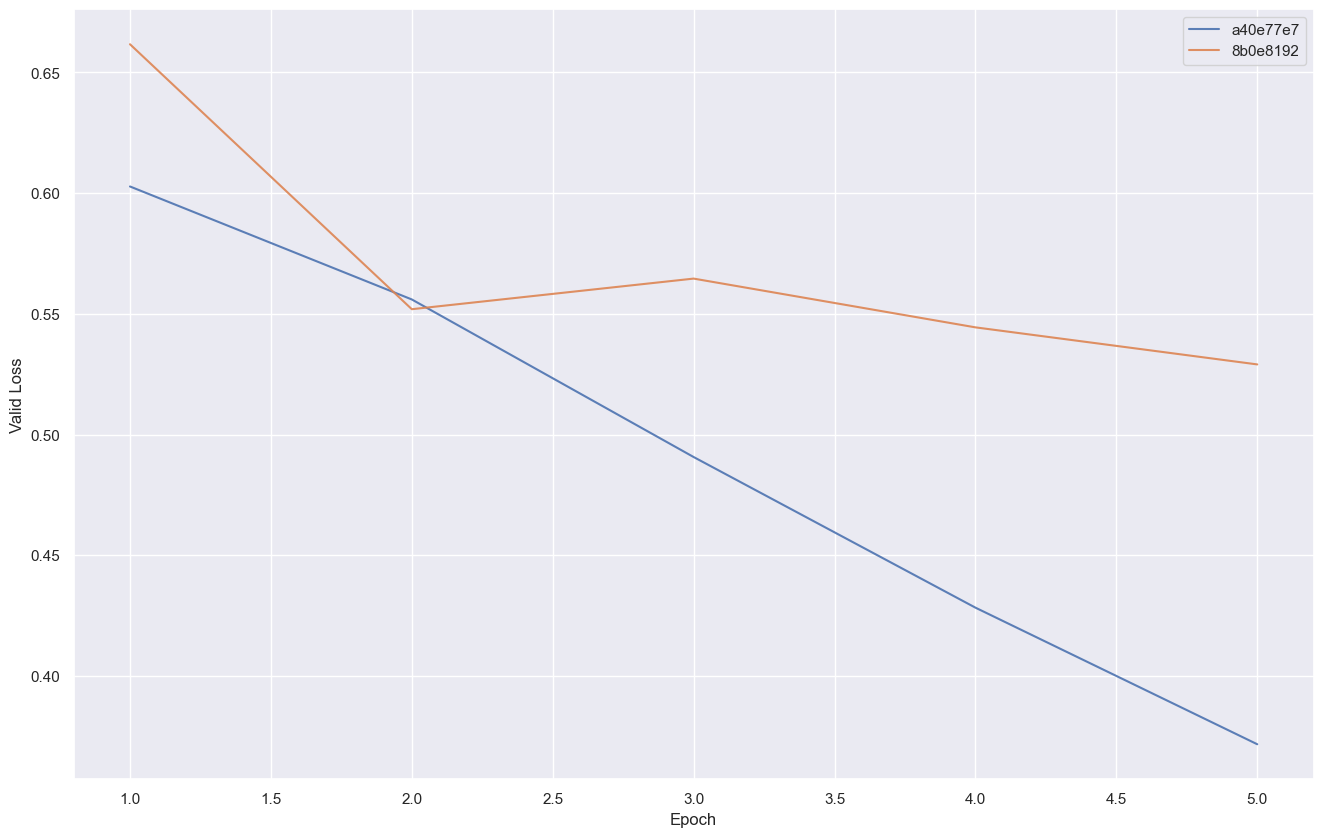

In [27]:
# Plot trials valid loss

cnn_raytune.plot_trials_loss(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

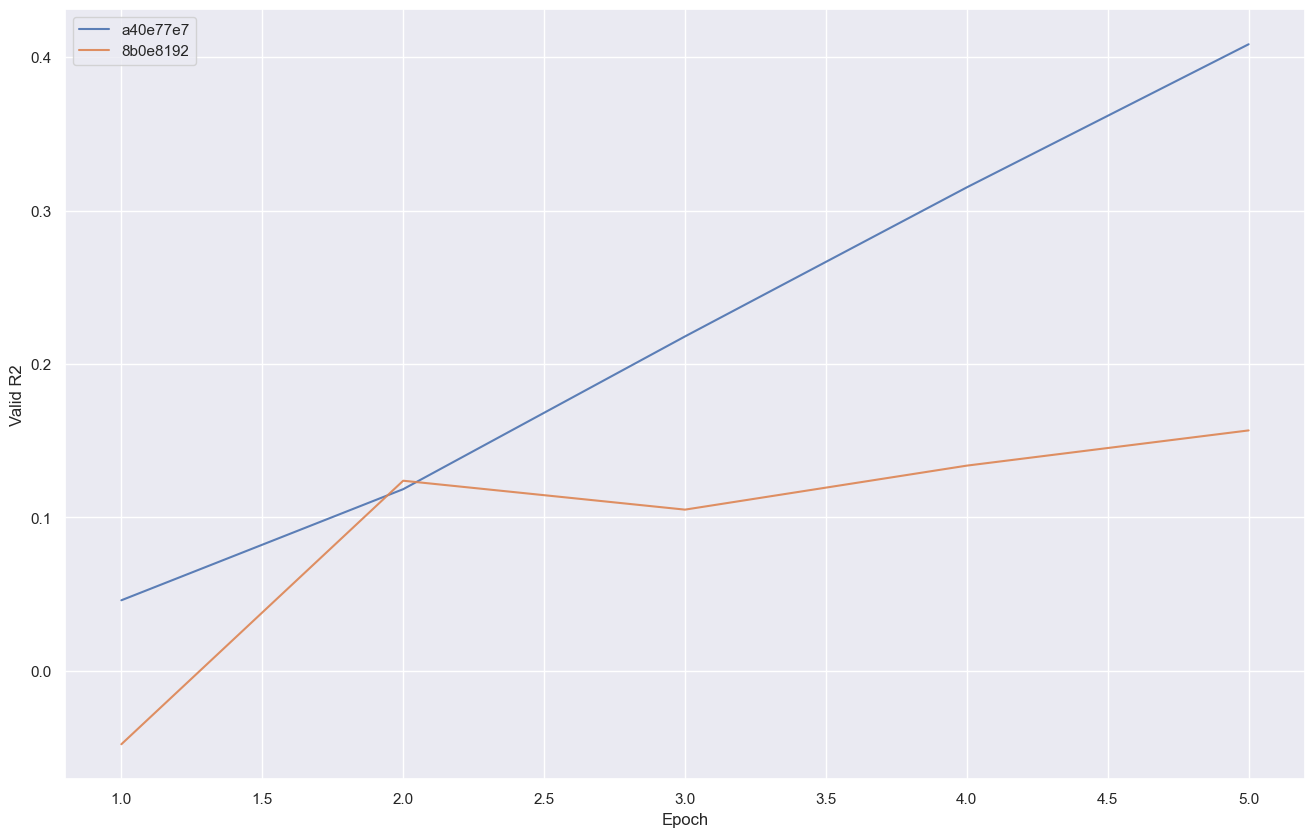

In [28]:
# Plot trials valid r2

cnn_raytune.plot_trials_r2(
	dataframe  = trials,
	max_trials = 10,
	alpha      = 0.9,
	filename   = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-trials')
)

### 2.4.2 Best

In [29]:
# Display best trial

best = report.get_best_result()

print('Best metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(best.metrics['valid_loss'], best.metrics['valid_r2']))
print('Best config : ')

for key, val in best.config.items() :
	if isinstance(key, str) : key = f'"{key}"'
	if isinstance(val, str) : val = f'"{val}"'

	print('{:30s} : {}'.format(key, val))

Best metric : loss =  0.37172 r2 =  0.40847
Best config : 
"dataset/batch_size"           : 32
"optimizer/name"               : "adam"
"optimizer/lr"                 : 3.262648825129617e-05
"optimizer/decay"              : 0.05530820765433695
"optimizer/momentum"           : 0.5857655085105684
"criterion/name"               : "mse"
"criterion/reduction"          : "mean"
"scheduler/name"               : "constant"
"scheduler/plateau/factor"     : 0.3798409889797759
"scheduler/plateau/patience"   : 4
"scheduler/linear/factor"      : 0.004318109387491916
"scheduler/step/factor"        : 0.16975929027771253
"scheduler/step/patience"      : 11
"scheduler/exponential/factor" : 0.9652544464799763
"model/dropout"                : 0.02
"model/conv1/filters"          : 32
"model/conv1/kernel"           : 11
"model/conv1/padding"          : "none"
"model/conv1/dilation"         : 1
"model/conv2/filters"          : 32
"model/conv2/kernel"           : 31
"model/conv2/padding"          : "same"
"mo

In [30]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(best.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'lr', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,lr,valid_loss,valid_r2,valid_mae,train_loss
0,a40e77e7,b4788fb469b341d7977cee5f9ebb2308,186.550,1,0.000,0.603,0.046,0.648,0.767
1,a40e77e7,b4788fb469b341d7977cee5f9ebb2308,344.032,2,0.000,0.556,0.118,0.618,0.579
2,a40e77e7,b4788fb469b341d7977cee5f9ebb2308,509.514,3,0.000,0.491,0.218,0.578,0.513
3,a40e77e7,b4788fb469b341d7977cee5f9ebb2308,655.834,4,0.000,0.428,0.315,0.535,0.448
4,a40e77e7,b4788fb469b341d7977cee5f9ebb2308,820.102,5,0.000,0.372,0.408,0.493,0.376


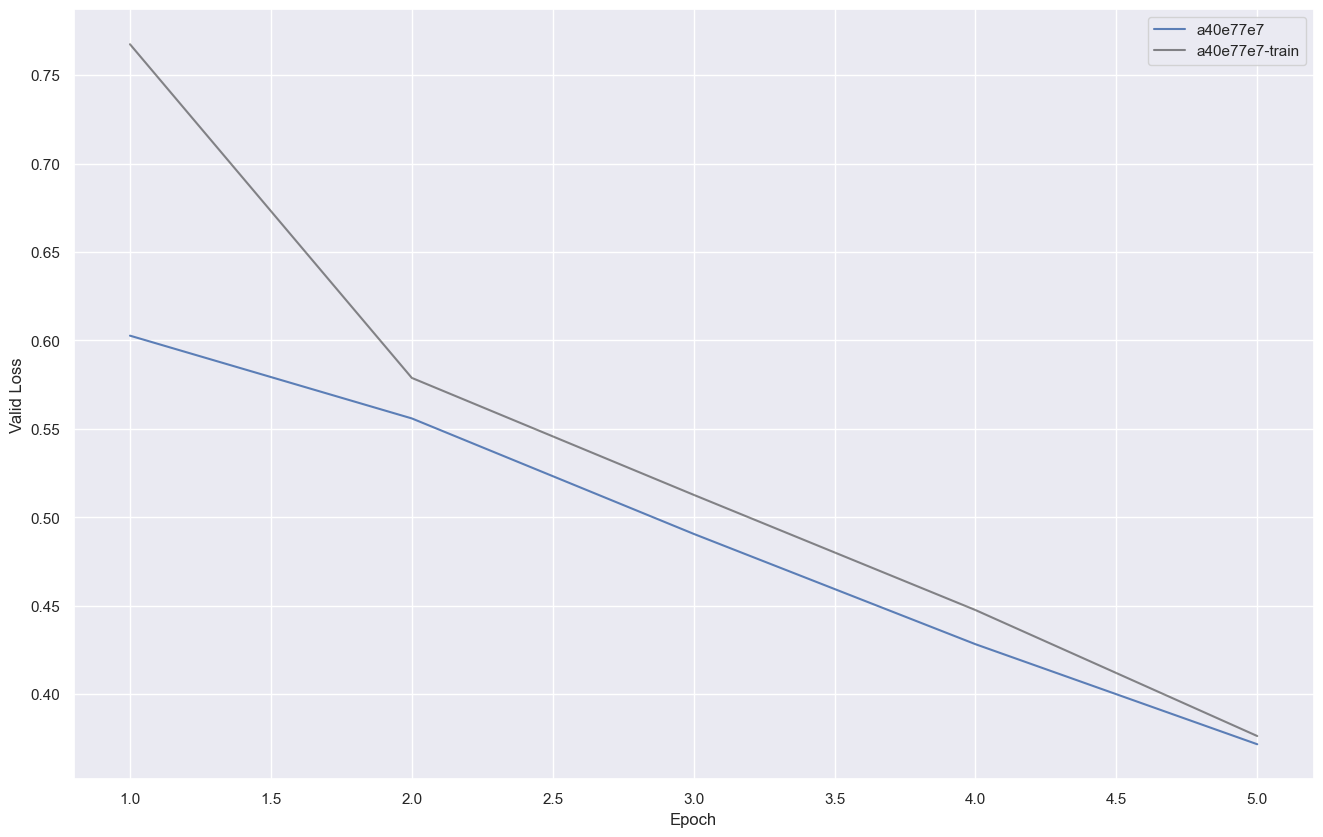

In [31]:
# Plot best trial valid loss

cnn_raytune.plot_trial_loss(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

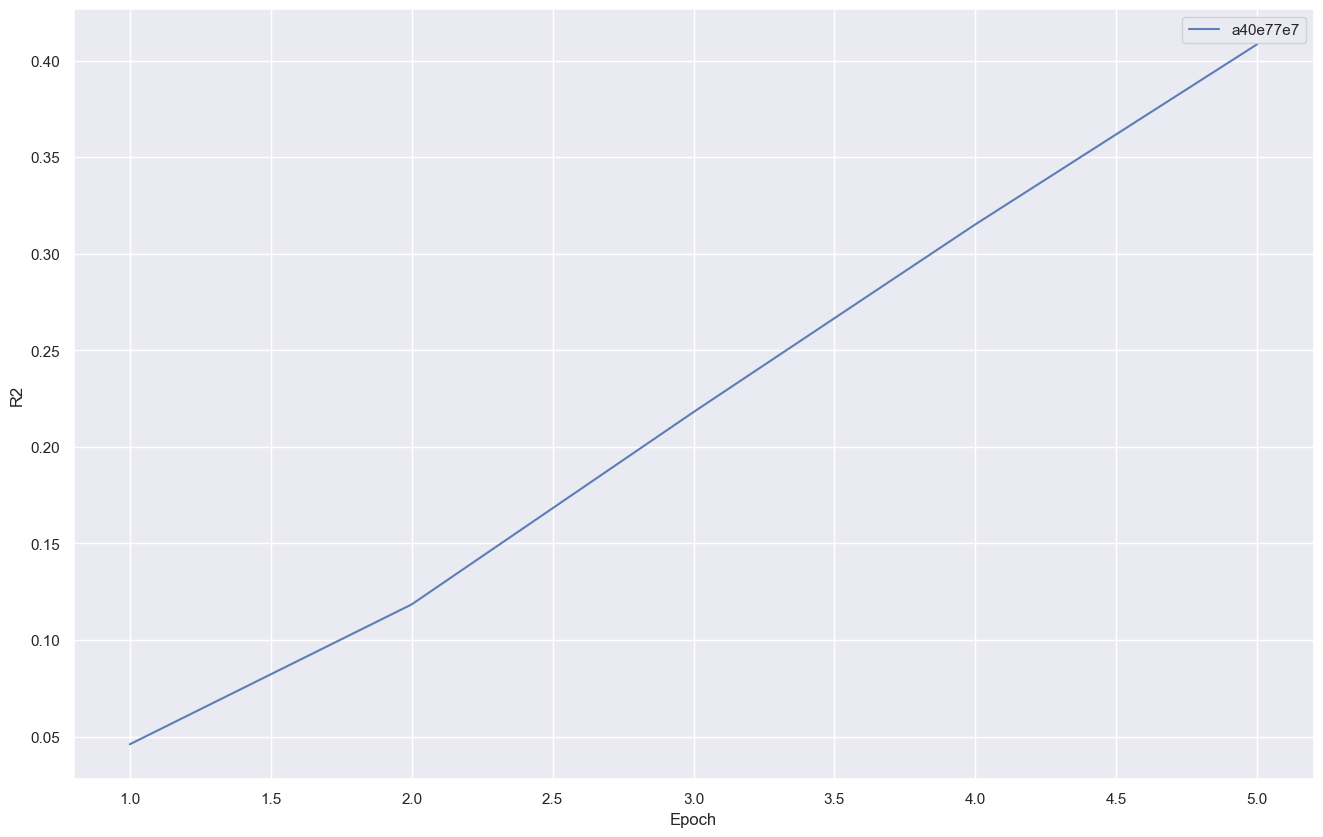

In [32]:
# Plot best trial valid r2

cnn_raytune.plot_trial_r2(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

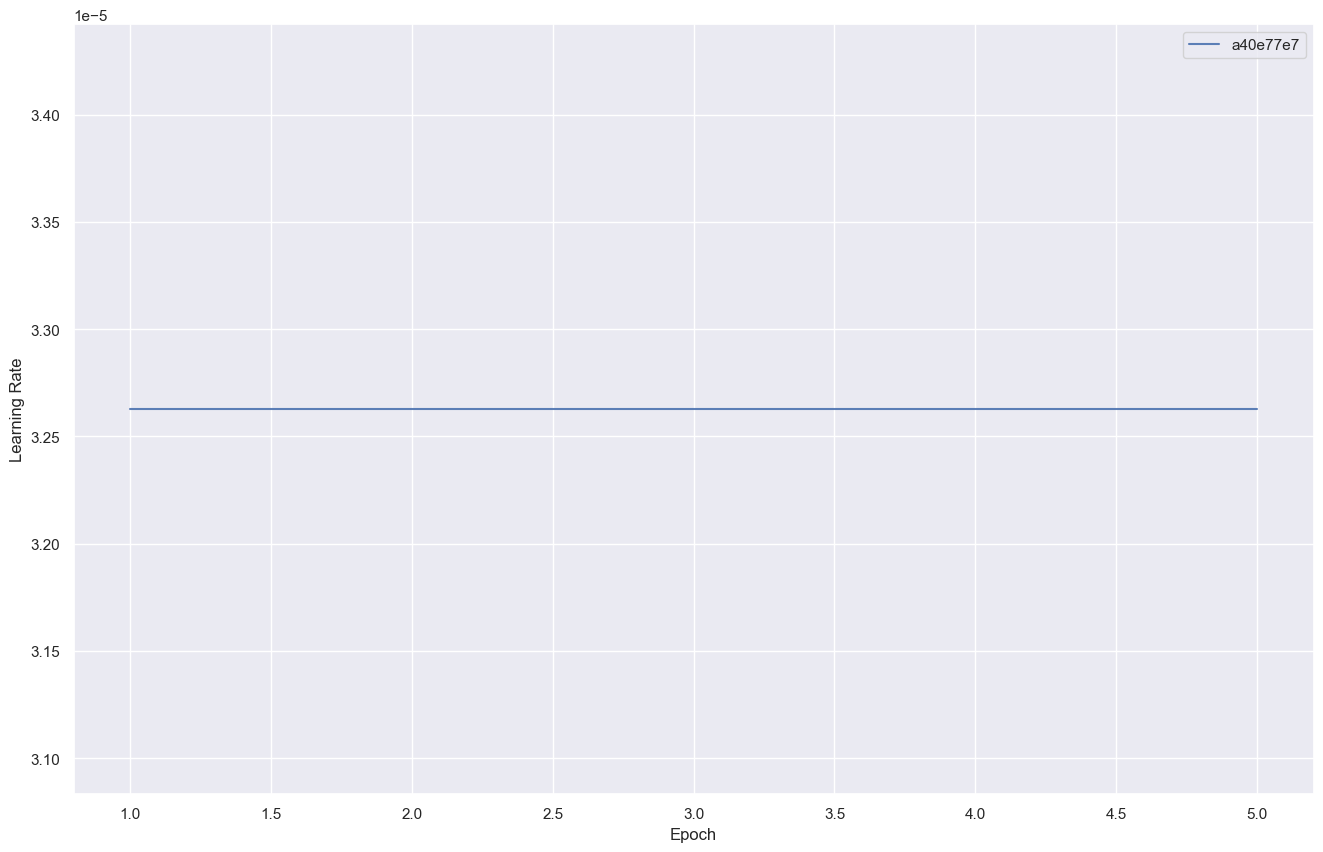

In [33]:
# Plot trials learning rate

cnn_raytune.plot_trial_lr(
	dataframe = progress,
	filename  = os.path.join(OUT_PLOT, CONFIG['model/type'] + '-best')
)

### 2.4.3 Worst

In [34]:
# Display worst trial

worst = report.get_best_result(metric = 'valid_loss', mode = 'max')

print('Worst metric : loss = {: 8.5f} r2 = {: 8.5f}'.format(worst.metrics['valid_loss'], worst.metrics['valid_r2']))
print('Worst config : ')

for key, val in best.config.items() :
	if isinstance(key, str) : key = f'"{key}"'
	if isinstance(val, str) : val = f'"{val}"'

	print('{:30s} : {}'.format(key, val))

Worst metric : loss =  0.52903 r2 =  0.15673
Worst config : 
"dataset/batch_size"           : 32
"optimizer/name"               : "adam"
"optimizer/lr"                 : 3.262648825129617e-05
"optimizer/decay"              : 0.05530820765433695
"optimizer/momentum"           : 0.5857655085105684
"criterion/name"               : "mse"
"criterion/reduction"          : "mean"
"scheduler/name"               : "constant"
"scheduler/plateau/factor"     : 0.3798409889797759
"scheduler/plateau/patience"   : 4
"scheduler/linear/factor"      : 0.004318109387491916
"scheduler/step/factor"        : 0.16975929027771253
"scheduler/step/patience"      : 11
"scheduler/exponential/factor" : 0.9652544464799763
"model/dropout"                : 0.02
"model/conv1/filters"          : 32
"model/conv1/kernel"           : 11
"model/conv1/padding"          : "none"
"model/conv1/dilation"         : 1
"model/conv2/filters"          : 32
"model/conv2/kernel"           : 31
"model/conv2/padding"          : "same"
"

In [35]:
# Display per iteration

progress = data_loader.load_csv(
	filename = os.path.join(worst.log_dir, 'progress.csv')
)

progress = progress[['trial_id', 'experiment_id', 'time_total_s', 'training_iteration', 'lr', 'valid_loss', 'valid_r2', 'valid_mae', 'train_loss']]
progress

,trial_id,experiment_id,time_total_s,training_iteration,lr,valid_loss,valid_r2,valid_mae,train_loss
0,8b0e8192,b46016b26d13461da65b1baeb9158e9b,258.292,1,0.003,0.662,-0.048,0.675,0.606
1,8b0e8192,b46016b26d13461da65b1baeb9158e9b,484.289,2,0.003,0.552,0.124,0.624,0.554
2,8b0e8192,b46016b26d13461da65b1baeb9158e9b,715.780,3,0.002,0.565,0.105,0.630,0.547
3,8b0e8192,b46016b26d13461da65b1baeb9158e9b,949.913,4,0.001,0.544,0.134,0.617,0.540
4,8b0e8192,b46016b26d13461da65b1baeb9158e9b,1189.484,5,0.001,0.529,0.157,0.604,0.523


## 2.5 Save

In [36]:
# Save the tuning results

report.get_dataframe().to_csv(
	os.path.join(OUT_DATA, CONFIG['model/type'] + '-report.csv')
)